# Project Time Series

In this notebook, I show my project on Time Series on Bitcoin using data from Yahoo Finance.

# Yahoo Finance Dataset

You can access Yahoo Finance by visiting the link below:



> https://finance.yahoo.com/quote/BTC-USD

This link will take you to a web page with a collection of Bitcoin-like market data that you can use in your project/research.



<img src="yahoo.png" width=80%><br/>


To search for a specific data set, use the search bar at the top of the screen. For example, let's say you want to search the Ethereum marketplace or a meme coin like Doge coin

<img src="yahoo2.png" width=80%><br/>

And finally, when you want to download data, go to the "Historical Data" tab and select the time you want to download. For example, select early 2020 to early 2023, then we click "Apply", then the time will change. After that, click "Download" to download the data.

### Import Library

This section imports the necessary libraries, including

1.  NumPy: A library that provides support for numerical operations and multidimensional arrays. Used for numerical data manipulation and processing.
2. Pandas: A library used for data manipulation and analysis. Pandas provides powerful data structures such as DataFrame, which makes it easy to process and transform data.
3. Matplotlib: A library for data visualization. Matplotlib allows the creation of various types of graphs and plots that aid in the understanding and visualization of data.
4. Scikit-learn: A library that provides various algorithms and functions for machine learning. Scikit-learn has features for data processing, modeling, evaluation, and model validation.
    - Sklearn.preprocessing: A module in scikit-learn that is used to perform data preprocessing such as scaling, encoding, and other processing before modeling.
    - Sklearn.metrics: A module in scikit-learn that provides various evaluation metrics to measure model performance, such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and others.
5. TensorFlow: An open-source library developed by Google for machine learning and deep learning. TensorFlow provides tools to build and train neural network models efficiently.

In [1]:
# Currently Python version that I am using is Python 3.10

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting the model

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

import warnings
warnings.filterwarnings('ignore') # ignoring any warning messages

### Data Loading and Preprocessing

In this section, there is data analysis and preprocessing first before scaling, creating sequence models, and training models.

- **```pd.read_csv```** is used to read data with a .csv formatted file.
- **```tail()```** this method returns the specified number of last rows.

In [2]:
# load CSV file data
df = pd.read_csv("BTC-USD.csv")
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1092,2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920
1093,2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479
1094,2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,16602.585938,15929162910
1095,2022-12-31,16603.673828,16628.986328,16517.519531,16547.496094,16547.496094,11239186456
1096,2023-01-01,16547.914063,16630.439453,16521.234375,16625.080078,16625.080078,9244361700


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


- **```info()```** This method prints information about the DataFrame

In [3]:
# quick look at out data types & null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1097 non-null   object 
 1   Open       1097 non-null   float64
 2   High       1097 non-null   float64
 3   Low        1097 non-null   float64
 4   Close      1097 non-null   float64
 5   Adj Close  1097 non-null   float64
 6   Volume     1097 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 60.1+ KB


- **```isnull().sum()```** This method checks whether the Dataframe contains missing values in each row and column.

In [4]:
# check if any missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

- extracts values from columns and gets an array.
- arrays can be used for scaling, sequence generation, or model training.

In [5]:
df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values 

#### Scale the Data

**```scaler = MinMaxScaler(feature_range = (0, 1))```**: This line creates an instance of the MinMaxScaler class. The ``feature_range`` parameter specifies the desired range for the scaled value. In this case, the range is set to (0, 1), which means that the scaled value will be between 0 and 1.

**```scaled_data = scaler.fit_transform(df)```**: The ``fit_transform()`` method of the scaler object is used to perform scaling operations on the data. It takes the input data df as an argument and returns the scaled data. Method ``fit_transform()`` performs two steps: first calculating the minimum and maximum values of the input data (fitting step), and then scaling the data using the calculated values (transformation step).

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

By applying **MinMaxScaler**, the data is transformed to a common scale where the minimum value of each feature becomes 0 and the maximum value becomes 1. This is useful to ensure that all features have equal influence on the machine learning model and prevents certain features from dominating others due to their larger scale.

#### Create Sequences for LSTM Input

In [7]:
# create sequences for LSTM input
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Length of input sequences
X, y = create_sequences(scaled_data, seq_length)

1. The ```create_sequences()``` function takes two inputs: ```data```, which is the input data, and ```seq_length```, which is the desired length of the input sequence.

2. Two empty lists, X and y, are initialized to store the input sequence and target value.

3. The function iterates over the data starting from the beginning and creates input-output pairs. For each iteration, it takes the sequence of length ```seq_length``` from the data and adds it to X, and the next value in the data to y.

4. After looping, the function returns X and y as a numpy array.

5. The function is called with ```scaled_data``` as input data and ```seq_length``` is set to 10. The resulting sequence is stored in variables X and y.

#### Splitting the Data into Training and Testing Sets

Training and testing sets using an 80-20 split

In [8]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

1. The variable **```train_size```** is calculated as 80% of the total number of input sequences (X).
2. The **```X_train```** is set as the first train_size sequence of X, which represents the training set.
3. **```X_test```** is assigned the remaining sequence of X, which represents the testing set.
4. Similarly, **```y_train```** is given the first **```train_size```** target value of y, and **```y_test```** is given the remaining target values.

#### Build the LSTM Model

In [9]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, 6)))  # Update input shape
model.add(Dense(6))  # Output has 6 features

1. **```model = Sequential()```**: This line creates an empty Sequential model.
2. **```model.add(LSTM(64, input_shape = (seq_length, 6)))```**: This line adds the LSTM layer to the model. The LSTM layer has 64 units and expects an input sequence of length ``seq_length`` with 6 features.
3. **```model.add(Dense(6))```**: This line adds the Dense layer to the model. The Dense layer has 6 neurons, which corresponds to the desired number of output features.

#### Set the Learning Rate with an Optimizer

In [10]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

1. **```learning_rate = 0.001```**: This line assigns a learning rate of 0.001 to the learning_rate variable. The learning rate determines the step size at which the optimizer updates the model parameters during training.
2. **```optimizer = Adam(learning_rate = learning_rate)```**: This line creates an example of the Adam optimizer with the specified learning rate. The Adam optimizer is a popular optimization algorithm used to train deep learning models.

#### Compile the Model

In [11]:
model.compile(optimizer=optimizer, 
              loss='mean_squared_error', 
              metrics=[MeanAbsoluteError()])

1. **```optimizer=optimizer```**: This parameter specifies the optimizer that will be used to train the model. In this case, the optimizer variable contains an example of Adam's optimizer with the specified learning rate.

2. **```loss = 'mean_squared_error'```**: This parameter specifies the loss function to be minimized during training. The mean squared error (MSE) loss function is commonly used for regression tasks, where the goal is to minimize the mean squared difference between the predicted and actual values.

3. **```metrics = [MeanAbsoluteError()]```**: This parameter specifies the evaluation metrics to be calculated during training. In this case, the ```MeanAbsoluteError()``` metric is used. Mean absolute error (MAE) is a common metric for regression tasks, which measures the average absolute difference between predicted and actual values.

### Train Model

In [12]:
epochs = 50
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/50
28/28 [==============================] - 2s 4ms/step - loss: 0.0770 - mean_absolute_error: 0.1776
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0046 - mean_absolute_error: 0.0533
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0381
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0322
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0305
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0299
Epoch 7/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0301
Epoch 8/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0290
Epoch 9/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0278
Epoch 10/50
28/28 [

#### Evaluate the Model

In [13]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

7/7 [==============================] - 0s 2ms/step


1. **```predict = model.predict(X_test)```**: This line uses the trained model to make predictions on the test data ``(X_test)``. The function ``model.predict()`` returns the predicted value for the given input data.

2. **```predictions = scaler.inverse_transform(predictions)```**: This line applies the inverse transformation to the prediction values using the scaler. Since the data was previously scaled using MinMaxScaler, this step returns the prediction values to their original scale.

3. **```y_test = scaler.inverse_transform(y_test)```**: This line applies an inverse transformation to the ground truth value (y_test) using the scaler. It returns the actual value to its original scale for comparison with the predicted value.

#### Checks if MAE is under 10% of the Total Scale of the Data

In [14]:
mae = np.mean(np.abs(predictions - y_test))
total_scale = np.max(df) - np.min(df)
mae_percent = (mae / total_scale) * 100

1. **```mae = np.mean(np.abs(prediction - y_test))```**: This line calculates the average absolute error (MAE) between the predicted value (prediction) and the ground truth value ```(y_test)```. The function ``np.abs()`` calculates the absolute difference between the predicted value and the actual value, and ``np.mean()`` calculates the average of these absolute differences.

2. **```total_scale = np.max(df) - np.min(df)```**: This line calculates the total scale of the data by finding the difference between the maximum and minimum values in the original Dataframe (df).

3. **```mae_percent = (mae / total_scale) * 100```**: This line calculates the MAE as a percentage of the total scale. It divides the MAE by the total scale and multiplies it by 100 to get the percentage value.

In [15]:
print('Mean Absolute Error (MAE):', mae)
print('MAE under 10% of total scale:', mae_percent <= 10)

Mean Absolute Error (MAE): 1250926691.6012616
MAE under 10% of total scale: True


### Plotting of Loss

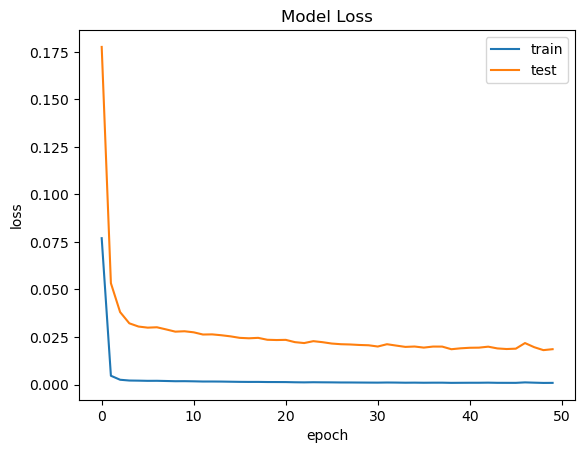

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()